# Prompt selection and testing

This notebook chooses the most appropriate prompt and prompt structure for the OCR correction. 

In [1]:
#import config  # Import your config.py file this contains you openai api key
import pandas as pd
import numpy as np
import os
from llm_comparison_toolkit import RateLimiter, get_response_openai,  create_config_dict_func, use_df_to_call_llm_api
from evaluate import load
from evaluation_funcs import evaluate_correction_performance, evaluate_correction_performance_folders, get_metric_error_reduction, evaluate_ocr_dataframe, calculate_metrics
import seaborn as sns
import matplotlib.pyplot as plt
from helper_functions import files_to_df_func, repeat_prompt_experiment, files_to_df_core_func
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
import re
from openai import OpenAI
import itertools
import tiktoken
save_figs = os.getenv("save_figs")

wer = load("wer")
cer = load("cer")
client = OpenAI()


dev_data_folder = 'data/dev_data'
dev_transcripts = os.path.join(dev_data_folder, 'dev_data_transcript')
dev_raw_ocr_folder =  os.path.join(dev_data_folder,'dev_raw_ocr' )
dev_system_message_folder = os.path.join(dev_data_folder,'dev_system_message_variants' )

#Overproof
overproof_folder = 'data/overproof'

smh_folder =  os.path.join(overproof_folder, 'SMH')
smh_articles_raw = os.path.join(smh_folder, 'line_level', 'line_raw')
smh_articles_transcribed = os.path.join(smh_folder, 'article_level', 'corrected') #in the dataset they are reffered to as corrected but this clashes with my naming convention
smh_articles_results = os.path.join(smh_folder, 'results')


# sociocultural test
socio_cultural_folder = "data/socio_cultural"
socio_cultural_results_folder = os.path.join(socio_cultural_folder, "results")
socio_cultural_evals = os.path.join(socio_cultural_folder, "evals")

#load the dev and test sets for prompt development and selection
dev_data_df = pd.read_csv(os.path.join(dev_data_folder,'dev_data_raw.csv'))



#for saving data to be used in the socio cultural
if not os.path.exists(socio_cultural_results_folder):
    os.makedirs(socio_cultural_results_folder)

if not os.path.exists(socio_cultural_evals):
    os.makedirs(socio_cultural_evals)

# Demonstrating context leveraging

The below texts can be used to demonstrate that LMs use context leveraging and that they can self-contextualise from the task itself. The words in the parenthesis are optional contxt

"""Please correct the below sentences containing OCR errors

My dog has no ***

*** did *** **** cross ***"""

In [3]:



response = get_response_openai(
    """Please correct the below sentences containing OCR errors

My dog has no ***

*** did *** **** cross ***""", 
"", RateLimiter(40000), 
engine="gpt-4-turbo-preview", 
max_tokens = 500)

2024-04-23 06:41:05 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [4]:

dog_nose = """My dog *** *** nose. 
How *** he ***? """

dog_nose = """My dog has no  ***"""

chicken_cross = "*** did *** **** cross ***"

chicken_cross = "why did the **** *** ***"


prompt_dog =f"""Please correct the below sentences containing OCR errors

{dog_nose}

"""

prompt_dog_joke =f"""Please correct the below sentences containing OCR errors, the sentence is part of a popular joke

{dog_nose}

"""

check_prompt_dog = """The below text surrounded by triple colons is the response of a language model to a task, did it correctly identify the sentence 'my dog has no nose', Answer 1 or 0
:::
{answer}
:::

"""

prompt_chicken =f"""Please correct the below sentences containing OCR errors

{chicken_cross}

"""

prompt_chicken_joke =f"""Please correct the below sentences containing OCR errors, the sentence is part of a popular joke

{chicken_cross}

"""

check_prompt_chicken = """The below text surrounded by triple colons is the response of a language model to a task, did it correctly identify the sentence 'why did the chicken cross the road', Answer 1 or 0
:::
{answer}
:::

"""


prompt_combined =f"""Please correct the below sentences containing OCR errors

{dog_nose}

{chicken_cross}
"""

prompt_combined_joke =f"""Please correct the below sentences containing OCR errors, the sentences are part of a popular jokes

{dog_nose}

{chicken_cross}
"""

check_combined = """The below text surrounded by triple colons is the response of a language model to a task, did it correctly identify both the sentences 'my dog has no nose' and 'why did the chicken cross the road', Answer 1 if both identified or 0 otherwise
:::
{answer}
:::

"""


In [5]:
context_check = pd.DataFrame([
             {'prompt': prompt_dog, 'check':check_prompt_dog, 'context':'no', 'joke':'dog' },
             {'prompt': prompt_dog_joke, 'check':check_prompt_dog, 'context':'yes', 'joke':'dog' },
             {'prompt': prompt_chicken, 'check':check_prompt_chicken, 'context':'no', 'joke':'chicken' },
             {'prompt': prompt_chicken_joke, 'check':check_prompt_chicken, 'context':'yes', 'joke':'chicken' },
             {'prompt': prompt_combined, 'check':check_combined, 'context':'no', 'joke':'combined' },
             {'prompt': prompt_combined_joke, 'check':check_combined, 'context':'yes', 'joke':'combined' }
            ])


context_results =[]
for index, row in context_check.iterrows():

    result = repeat_prompt_experiment(row['prompt'] , row['check'] , client, repititions = 100)

    result['context'] = row['context']
    result['joke'] = row['joke']

    context_results.append(result)


context_results = pd.concat(context_results, ignore_index=True)

#context_results.to_csv("does_LM_use_context_results.csv")

2024-04-23 06:41:06 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-04-23 06:41:06 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-04-23 06:41:08 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-04-23 06:41:09 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-04-23 06:41:10 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-04-23 06:41:10 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


KeyboardInterrupt: 

# Spoofing and **T**ask **I**nduced **I**n **C**ontext **L**earning

This section performs the test of how the amount of text and the prompt given interact.

In [9]:
def split_rows(df, x):
    new_rows = []
    
    for _, row in df.iterrows():
        content_lines = row['content'].split('\n')
        num_groups = len(content_lines) // x
        
        for i in range(num_groups):
            start_row = i * x
            end_row = (i + 1) * x
            group_lines = content_lines[start_row:end_row]
            
            new_row = {
                'file_name': row['file_name'],
                'content': '\n'.join(group_lines),
                'start_row': start_row,
                'end_row': end_row
            }
            new_rows.append(new_row)
    
    new_df = pd.DataFrame(new_rows)
    new_df['content'] = new_df['content'].str.replace("-\n", "").str.replace("\n", " ")
    new_df['id2'] = new_df['file_name'].str.replace(".txt", "")
    new_df['id'] = new_df['id2'] + "_lines_" + new_df['start_row'].astype(str) + "_" + new_df['end_row'].astype(str) 
    new_df['file_name'] = new_df['id'] + ".txt" 
    return new_df

In [10]:
prompt_smh = "{content}"+f""" \n \n """ + f"""You are an expert in post-OCR correction of documents. Using the context available from the text please recover the most likely original text from the corrupted OCR. Do not add any text, commentary, or lead in sentences beyond the recovered text. Do not add a title, or any introductions."""
context_prompt_smh = "{content}"+f""" \n \n """ + f"""You are an expert in post-OCR correction of documents. Using the context available from the text please recover the most likely original text from the corrupted OCR. Do not add any text, commentary, or lead in sentences beyond the recovered text. Do not add a title, or any introductions. The text is from The Sydney Morning Herald 1842 -1950. """
spoof_prompt_smh = "{content}"+f""" \n \n """ + f"""You are an expert in post-OCR correction of documents. Using the context available from the text please recover the most likely original text from the corrupted OCR. Do not add any text, commentary, or lead in sentences beyond the recovered text. Do not add a title, or any introductions. The text is from The Hong Kong Restaurant Review 1989-1993. """




In [11]:
enc = tiktoken.encoding_for_model("gpt-3.5-turbo") 

In [12]:
prompt_dict = {'prompt':[prompt_smh, context_prompt_smh, spoof_prompt_smh],
 'response_name':['basic', 'context', 'spoof']
 }


socio_list = [
    create_config_dict_func(
        get_response_func=get_response_openai,
        rate_limiter=RateLimiter(160e3),
        engine='gpt-3.5-turbo',
        system_message_template="",
        prompt_template=prompt_dict['prompt'][num],
        additional_args={"response_name": prompt_dict['response_name'][num]} ## will be added to in the loop
    )
    for num in  [0,1,2]
]


In [13]:

max_article_rows = 60

raw_article_ocr_df= files_to_df_core_func("data/overproof/SMH/article_level/raw")

# Filter the DataFrame to keep rows with at least 50 line breaks
raw_article_ocr_df = raw_article_ocr_df[raw_article_ocr_df['content'].str.count('\n') >= max_article_rows]

# Split the 'content' column into a list of lines and take the first 50 lines
raw_article_ocr_df['content'] = raw_article_ocr_df['content'].apply(lambda x: '\n'.join(x.split('\n')[:max_article_rows]))



In [14]:
number_lines_list =[60, 30, 15, 10, 5, 2]  #[1, 2, 3, 4, 5, 6, 10, 12, 15, 20, 30, 60]

for config, group_size in itertools.product(socio_list, number_lines_list ):

    temporary_df = split_rows(raw_article_ocr_df, group_size)

    response_name = config['response_name'] + "_" + str(group_size)

    use_df_to_call_llm_api(config, temporary_df, response_name , folder_path= os.path.join(socio_cultural_results_folder ))

In [15]:
#load transcribed data

transcr_article_ocr_df= files_to_df_core_func(smh_articles_transcribed)

# Filter the DataFrame to keep rows with at least 50 line breaks
transcr_article_ocr_df = transcr_article_ocr_df[transcr_article_ocr_df['content'].str.count('\n') >= max_article_rows]

# Split the 'content' column into a list of lines and take the first 50 lines
transcr_article_ocr_df['content'] = transcr_article_ocr_df['content'].apply(lambda x: '\n'.join(x.split('\n')[:max_article_rows]))

transcr_article_ocr_df['content']  = transcr_article_ocr_df['content'].str.replace("-\n", "").str.replace("\n", " ")

transcr_article_ocr_df['id'] = transcr_article_ocr_df['file_name'].str.replace(".txt", "")

transcr_article_ocr_df.drop(columns='file_name', inplace=True)

In [18]:
socio_cultural_results_folder

'data/socio_cultural/results'

In [19]:
# go through all the folders and get the performance

performance_vs_lines = []



for folder in os.listdir(socio_cultural_results_folder):
    agg_num =  int(re.search(r'_(\d+)_', folder).group(1))
    print(f"folder:{folder}, lines agg:{agg_num}")


    lm_corrected_temp = files_to_df_core_func(os.path.join(socio_cultural_results_folder, folder))

    lm_corrected_temp['id'] = lm_corrected_temp['file_name'].str.extract(r'(.+)_lines_')[0]
    lm_corrected_temp['order'] = lm_corrected_temp['file_name'].str.extract(r'_lines_(\d+)')[0].astype(int)

    # Group by the grouping key and aggregate the content based on the order
    lm_corrected_temp = lm_corrected_temp.groupby('id')[['order', 'content']].apply(lambda x: ' '.join(x.sort_values('order')['content']))

    # Reset the index to get the grouping key as a regular column
    lm_corrected_temp = lm_corrected_temp.reset_index(name='content').reset_index(drop = True).rename(columns={0:'content'})

    #merge together
    current_article_set = transcr_article_ocr_df.merge(lm_corrected_temp, left_on='id', right_on = 'id', suffixes=['_transcr', '_lm'])

    metric_df = pd.concat([calculate_metrics(row['id'], row['content_lm'].lower(), row['content_transcr'].lower(), wer, cer) for _, row in current_article_set.iterrows()]).drop(columns='File Name')

    current_article_set.loc[:, ['WER', 'CER', 'lev_dist']] = metric_df[['WER', 'CER', 'lev_dist']].reset_index()

    result_df = metric_df.agg(['mean', 'median'])

    result_df['average'] = ['mean', 'median']

    result_df['lines'] = agg_num
    result_df['type'] = folder

    current_article_set['lines'] = agg_num
    current_article_set['type'] = folder

    current_article_set.to_csv(os.path.join(socio_cultural_evals, folder+".csv"))

    performance_vs_lines.append(result_df)

performance_vs_lines = pd.concat(performance_vs_lines, ignore_index=True)

performance_vs_lines['type'] =  performance_vs_lines['type'].str.split("_").str.get(0)

folder:basic_10_gpt-3.5-turbo, lines agg:10
folder:basic_60_gpt-3.5-turbo, lines agg:60
folder:context_60_gpt-3.5-turbo, lines agg:60
folder:context_30_gpt-3.5-turbo, lines agg:30
folder:basic_30_gpt-3.5-turbo, lines agg:30
folder:basic_5_gpt-3.5-turbo, lines agg:5
folder:spoof_30_gpt-3.5-turbo, lines agg:30
folder:basic_2_gpt-3.5-turbo, lines agg:2
folder:spoof_2_gpt-3.5-turbo, lines agg:2
folder:context_15_gpt-3.5-turbo, lines agg:15
folder:context_10_gpt-3.5-turbo, lines agg:10
folder:context_5_gpt-3.5-turbo, lines agg:5
folder:context_2_gpt-3.5-turbo, lines agg:2
folder:basic_15_gpt-3.5-turbo, lines agg:15
folder:spoof_15_gpt-3.5-turbo, lines agg:15
folder:spoof_5_gpt-3.5-turbo, lines agg:5
folder:spoof_10_gpt-3.5-turbo, lines agg:10
folder:spoof_60_gpt-3.5-turbo, lines agg:60


2024-05-01 06:56:24 matplotlib.category INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-01 06:56:24 matplotlib.category INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


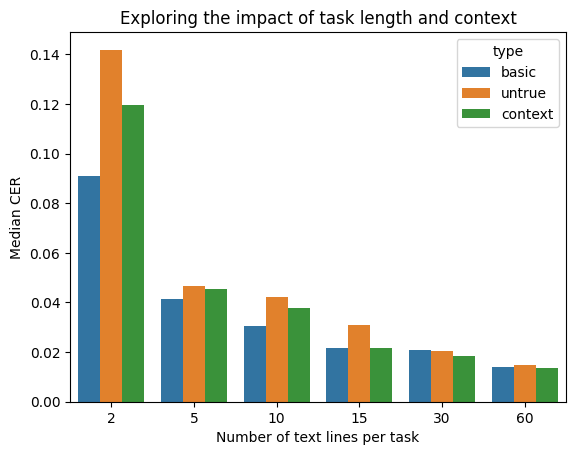

In [31]:
temp_plot = performance_vs_lines.loc[(performance_vs_lines['average']=='median')].copy()
temp_plot['type'] = temp_plot['type'].str.replace("spoof", 'untrue')
temp_plot['lines'] = temp_plot['lines'].astype(int)

sns.barplot(data =temp_plot, x = 'lines', y = 'CER', hue = 'type')
plt.title('Exploring the impact of task length and context')
plt.xlabel('Number of text lines per task')
plt.ylabel('Median CER')
plt.savefig(os.path.join(save_figs,"performance_vs_lines.pdf"))
plt.show()

Text(0.5, 1.0, 'Exploring the impact of task length and context')

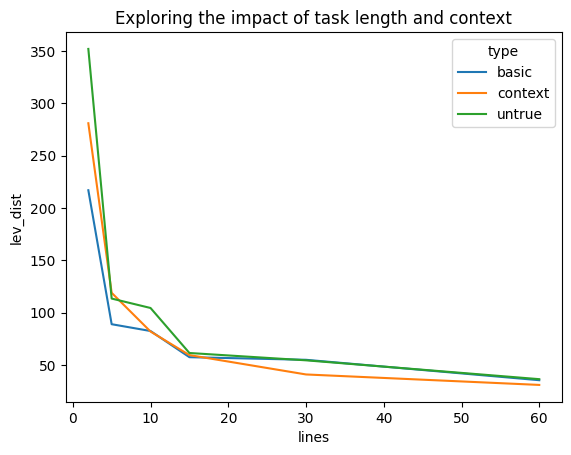

In [ ]:
sns.lineplot(data=temp_plot, 
            x='lines', y='lev_dist', hue='type')
plt.title('Exploring the impact of task length and context')